In [ ]:

#####################################################
# Advanced Machine Learning                         #
# Assignment 2 - Convolution - Cats Vs Dogs data set#
# Name: Divya Chandrasekaran                        #
# Due Date: 24/03/2024                              #
#####################################################

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 97% 790M/812M [00:04<00:00, 201MB/s]
100% 812M/812M [00:04<00:00, 203MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq test1.zip

In [ ]:
!unzip -qq train.zip


#**Question 1**

Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text).

Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch.

What performance did you achieve?




**Copying images to training, validation, and test directories.**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Initially taking 1000 samples for training set
make_subset("train", start_index=0, end_index=1000)
#500 samples for validation set
make_subset("validation", start_index=1000, end_index=1500)
#500 for test set
make_subset("test", start_index=1500, end_index=2000)

#**Data preprocessing**

**Using image_dataset_from_directory to read images**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)


In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(4, 4)
(4, 4)
(4, 4)


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)



#**Using Convolution Neural Networks**

**Building the model**


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

From the above model summary, we can observe that the model might overfit, and so it's best to use regularization techniques in data processing stage.

Next, we will have to convert all the images to tensors.

#**Fitting the model using a Dataset**

Callbacks are generally used to save the model's weights after every epoch or to stop training early if the model is not improving.

Moreover, these callbacks are mainly used to log metrics, visualize the model's performance, or schedule learning rate changes.



In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 19s 76ms/step - loss: 0.7079 - accuracy: 0.5215 - val_loss: 0.6996 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 5s 82ms/step - loss: 0.6932 - accuracy: 0.5165 - val_loss: 0.6991 - val_accuracy: 0.5010
Epoch 3/30
63/63 [==============================] - 4s 66ms/step - loss: 0.6811 - accuracy: 0.5635 - val_loss: 0.6962 - val_accuracy: 0.5660
Epoch 4/30
63/63 [==============================] - 5s 80ms/step - loss: 0.6561 - accuracy: 0.6260 - val_loss: 0.6193 - val_accuracy: 0.6720
Epoch 5/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6277 - accuracy: 0.6675 - val_loss: 0.6385 - val_accuracy: 0.6490
Epoch 6/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6176 - accuracy: 0.6675 - val_loss: 0.5838 - val_accuracy: 0.6710
Epoch 7/30
63/63 [==============================] - 5s 82ms/step - loss: 0.5976 - accuracy: 0.6845 - val_loss: 0.5699 - val_accuracy: 0.7090
Epoch 8/30
6

#**Displaying curves of loss and accuracy during training**



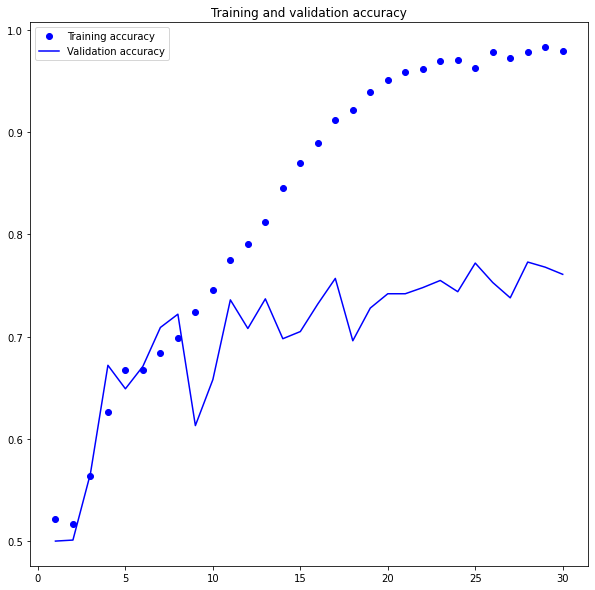

<Figure size 432x288 with 0 Axes>

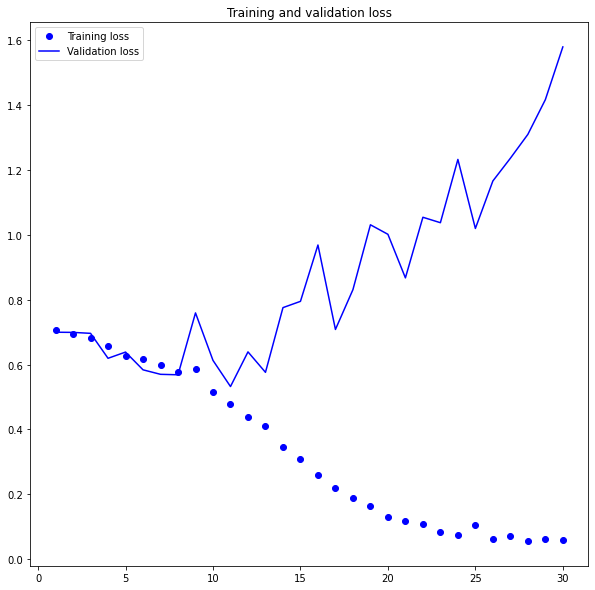

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the model on the test set



In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 46ms/step - loss: 0.5640 - accuracy: 0.7210
Test accuracy: 0.721


Here we got training accurracy as 97.95%, validation accuracy as 76.1% and test accuracy 72.1%



#**Question 2**

Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?



**Using data augmentation**


**Define a data augmentation stage to add to an image model**

In [ ]:

import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Here I have increased training sample size to 1500 and keeping the validation and test sample size to 500 each as before
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

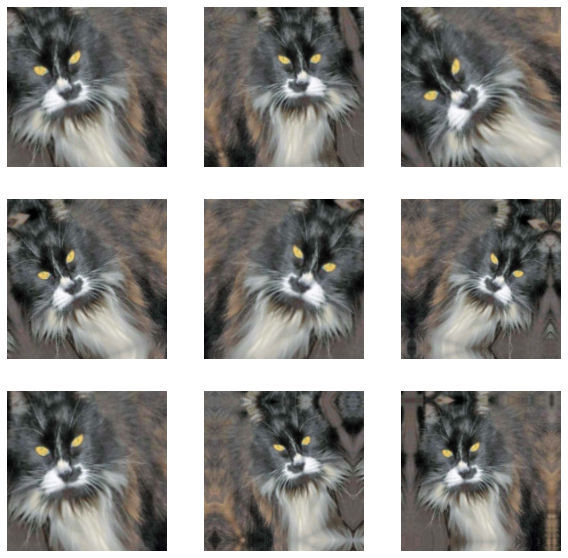

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


#**Defining a new convnet that includes image augmentation and dropout**



In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#**Training the regularized convnet**


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/20


63/63 [==============================] - 18s 213ms/step - loss: 0.6962 - accuracy: 0.5030 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 14s 216ms/step - loss: 0.6934 - accuracy: 0.5055 - val_loss: 0.6918 - val_accuracy: 0.5340
Epoch 3/20
63/63 [==============================] - 16s 252ms/step - loss: 0.6888 - accuracy: 0.5575 - val_loss: 0.7942 - val_accuracy: 0.5030
Epoch 4/20
63/63 [==============================] - 16s 244ms/step - loss: 0.6912 - accuracy: 0.5750 - val_loss: 0.6571 - val_accuracy: 0.6350
Epoch 5/20
63/63 [==============================] - 14s 212ms/step - loss: 0.6541 - accuracy: 0.6330 - val_loss: 0.6311 - val_accuracy: 0.6460
Epoch 6/20
63/63 [==============================] - 13s 209ms/step - loss: 0.6369 - accuracy: 0.6385 - val_loss: 0.6825 - val_accuracy: 0.5690
Epoch 7/20
63/63 [==============================] - 15s 241ms/step - loss: 0.6359 - accuracy: 0.6490 - val_loss: 0.6193 - val_accuracy: 0.6630
Epoch 8/20

#**Evaluating the model on the test set**


In [ ]:

test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 29ms/step - loss: 0.6054 - accuracy: 0.7380
Test accuracy: 0.738


#**Question 3**

Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps.

The objective is to find the ideal training sample size to get best prediction results.

In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#As increasing the sample size is always good than decreasing, here we're increasing the training the sample size to 2000
make_subset("train", start_index=0, end_index=2000)
#validation and test sample size 500 each
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20


63/63 [==============================] - 20s 227ms/step - loss: 0.6967 - accuracy: 0.4855 - val_loss: 0.6910 - val_accuracy: 0.5010
Epoch 2/20
63/63 [==============================] - 14s 212ms/step - loss: 0.6866 - accuracy: 0.5600 - val_loss: 0.6708 - val_accuracy: 0.5890
Epoch 3/20
63/63 [==============================] - 14s 211ms/step - loss: 0.6686 - accuracy: 0.5895 - val_loss: 0.6593 - val_accuracy: 0.6070
Epoch 4/20
63/63 [==============================] - 17s 262ms/step - loss: 0.6625 - accuracy: 0.5965 - val_loss: 0.6532 - val_accuracy: 0.6110
Epoch 5/20
63/63 [==============================] - 14s 220ms/step - loss: 0.6396 - accuracy: 0.6475 - val_loss: 0.6371 - val_accuracy: 0.6270
Epoch 6/20
63/63 [==============================] - 13s 210ms/step - loss: 0.6394 - accuracy: 0.6350 - val_loss: 0.6686 - val_accuracy: 0.5900
Epoch 7/20
63/63 [==============================] - 14s 223ms/step - loss: 0.6551 - accuracy: 0.6155 - val_loss: 0.6310 - val_accuracy: 0.6410
Epoch 8/20

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


32/32 [==============================] - 1s 29ms/step - loss: 0.5207 - accuracy: 0.7510
Test accuracy: 0.751


#**Question 4**


Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch.


Again, use any and all optimization techniques to get best performance.


#**Leveraging a pretrained model**

**Feature extraction with a pretrained model**

**Initiating the VGG16 convolutional base**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#**Fast feature extraction without data augmentation.**





#Extracting the VGG16 features and corresponding labels



In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 37ms/step


In [ ]:
train_features.shape

(2000, 5, 5, 512)

#**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 18.9551 - accuracy: 0.9270 - val_loss: 9.9199 - val_accuracy: 0.9350
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 3.6992 - accuracy: 0.9740 - val_loss: 11.6989 - val_accuracy: 0.9340
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2.8605 - accuracy: 0.9835 - val_loss: 3.8736 - val_accuracy: 0.9720
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1.2347 - accuracy: 0.9925 - val_loss: 5.6308 - val_accuracy: 0.9710
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.3904 - accuracy: 0.9925 - val_loss: 6.7464 - val_accuracy: 0.9700
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 1.5087 - accuracy: 0.9905 - val_loss: 3.9349 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.1161 - accuracy: 0.9965 - val_loss: 4.7942 - val_accuracy: 0.9720
Epoch 8/20
63/63 

#**Plotting the results**



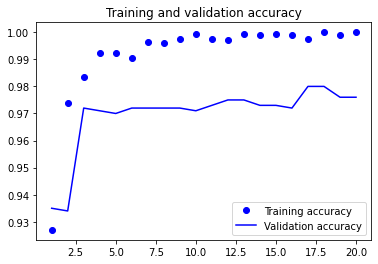

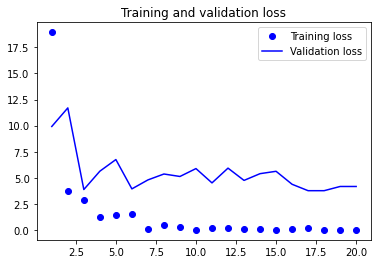

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#**Feature extraction together with data augmentation.**

#**Initiating and freezing the VGG16 convolutional base**



In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


#**Printing the list of trainable weights before and after freezing**


In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


#**Adding a data augmentation stage and a classifier to the convolutional base**



In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10


63/63 [==============================] - 23s 299ms/step - loss: 19.6682 - accuracy: 0.8935 - val_loss: 3.5151 - val_accuracy: 0.9640
Epoch 2/10
63/63 [==============================] - 18s 282ms/step - loss: 7.8176 - accuracy: 0.9420 - val_loss: 3.5388 - val_accuracy: 0.9700
Epoch 3/10
63/63 [==============================] - 18s 281ms/step - loss: 5.4542 - accuracy: 0.9630 - val_loss: 6.7396 - val_accuracy: 0.9570
Epoch 4/10
63/63 [==============================] - 22s 347ms/step - loss: 5.0911 - accuracy: 0.9625 - val_loss: 4.9181 - val_accuracy: 0.9700
Epoch 5/10
63/63 [==============================] - 19s 302ms/step - loss: 2.5755 - accuracy: 0.9715 - val_loss: 12.2249 - val_accuracy: 0.9490
Epoch 6/10
63/63 [==============================] - 20s 321ms/step - loss: 3.3433 - accuracy: 0.9740 - val_loss: 4.7799 - val_accuracy: 0.9740
Epoch 7/10
63/63 [==============================] - 18s 291ms/step - loss: 2.9975 - accuracy: 0.9715 - val_loss: 4.4656 - val_accuracy: 0.9730
Epoch 8/

#**Evaluating the model on the test set**



In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 89ms/step - loss: 5.5864 - accuracy: 0.9770
Test accuracy: 0.977


#**Fine-tuning a pretrained model**


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#**Freezing all layers until the fourth from the last**


In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

#**Fine-tuning the model**



In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10


63/63 [==============================] - 25s 312ms/step - loss: 3.4986 - accuracy: 0.9675 - val_loss: 3.3660 - val_accuracy: 0.9710
Epoch 2/10
63/63 [==============================] - 19s 298ms/step - loss: 1.9667 - accuracy: 0.9690 - val_loss: 2.4767 - val_accuracy: 0.9750
Epoch 3/10
63/63 [==============================] - 20s 312ms/step - loss: 1.2854 - accuracy: 0.9765 - val_loss: 1.8823 - val_accuracy: 0.9760
Epoch 4/10
63/63 [==============================] - 21s 329ms/step - loss: 0.7166 - accuracy: 0.9830 - val_loss: 2.2937 - val_accuracy: 0.9760
Epoch 5/10
63/63 [==============================] - 19s 294ms/step - loss: 0.7721 - accuracy: 0.9830 - val_loss: 2.3833 - val_accuracy: 0.9700
Epoch 6/10
63/63 [==============================] - 19s 304ms/step - loss: 0.9871 - accuracy: 0.9810 - val_loss: 2.1241 - val_accuracy: 0.9750
Epoch 7/10
63/63 [==============================] - 19s 295ms/step - loss: 0.8472 - accuracy: 0.9800 - val_loss: 2.1078 - val_accuracy: 0.9800
Epoch 8/10

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 90ms/step - loss: 2.7408 - accuracy: 0.9790
Test accuracy: 0.979
